In [1]:
import numpy as np
import matplotlib.pyplot as plt
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup, prepare_psf_model, FittableImageModel
from photutils.background import MMMBackground, MADStdBackgroundRMS
from photutils.psf import IterativelySubtractedPSFPhotometry, DAOPhotPSFPhotometry
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm
from astropy.io import fits
from astropy.visualization import simple_norm
import galsim.roman
import galsim as gs
import scipy as sp
import scipy.optimize as opt
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
import pandas as pd

# DC2 Data

In [2]:
#star truths
fits_image_filename = 'dc2_test_index_star.fits'
hdul = fits.open(fits_image_filename)
hdul.info()

Filename: dc2_test_index_star.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU     44   51771R x 18C   [K, K, K, D, D, D, D, D, K, K, K, K, K, D, D, D, D, K]   


In [3]:
#galaxy truths
fits_image_filename = 'dc2_test_index.fits'
hdul2 = fits.open(fits_image_filename)
hdul2.info()

Filename: dc2_test_index.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU     44   8840004R x 18C   [K, K, K, D, D, D, D, D, K, K, K, K, K, D, D, D, D, K]   


In [4]:
dat = Table.read('dc2_test_index_star.fits', format='fits')
stars = dat.to_pandas()

In [5]:
dat = Table.read('dc2_test_index.fits', format='fits')
gals = dat.to_pandas()

In [6]:
stars = stars.drop_duplicates(subset=['ind'])

In [7]:
gals =  gals.drop_duplicates(subset=['ind'])

In [8]:
#define star ra and dec cuts 
dd = 0.453258*8825*.0575/60/60/2
ddd = 0.453258*8825*.0745/60/60/2 #possible typo in code
dtr = np.pi/180
mask1 =np.where((stars['ra']>= (55.55882977-ddd)*dtr)&(stars['ra']<= (55.55882977+ddd)*dtr)&(stars['dec']>= (-39.98296726-dd)*dtr)&(stars['dec']<= (-39.98296726+dd)*dtr))

In [9]:
#define galaxy ra and dec cuts for the 4000x4000 space
dd = 0.453258*8825*.0575/60/60/2
ddd = 0.453258*8825*.0745/60/60/2 #possible typo in code
dtr = np.pi/180
mask2 =np.where((gals['ra']>= (55.55882977-ddd)*dtr)&(gals['ra']<= (55.55882977+ddd)*dtr)&(gals['dec']>= (-39.98296726-dd)*dtr)&(gals['dec']<= (-39.98296726+dd)*dtr))#&(gals['mag']>17.5)&(gals['mag']<19)

In [10]:
#Image used
fits_image_filename = 'dc2_test_H158_55.51_-39.9.fits'
dul = fits.open(fits_image_filename)
dul.info()

Filename: dc2_test_H158_55.51_-39.9.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     908   ()      
  1  SCI           1 ImageHDU        63   (8825, 8825)   float32   
  2  WHT           1 ImageHDU        64   (8825, 8825)   float32   
  3  CTX           1 ImageHDU        63   (8825, 8825)   int32   
  4  HDRTAB        1 BinTableHDU    559   21R x 275C   [8A, 3A, K, D, D, D, D, D, D, D, D, D, D, D, D, K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, K, D, D, D, D, D, D, D, D, D, D, D, 11A, D, 4A, D, D, K, K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 12A, 12A, D, D, D, D, D, D, D, D, D, 2A, D, D, D, D, D, D, D, D, D, 12A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 4A, D, D, 4A, D, D, D, D, D, D, D, D, D, D, D, D, K, K, D, K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D

In [11]:
#convert wc to pixel coordinates
wcs = WCS(header=dul[2].header)

In [12]:
scs = SkyCoord(ra=stars['ra'].values[mask1]*u.radian, dec=stars['dec'].values[mask1]*u.radian)

In [13]:
#star pixels
xs,ys = wcs.world_to_pixel(scs)

In [14]:
scg = SkyCoord(ra=gals['ra'].values[mask2]*u.radian, dec=gals['dec'].values[mask2]*u.radian)

In [15]:
#galaxy pixels
xg,yg = wcs.world_to_pixel(scg)

# Generate PSF Model

In [16]:
romanpsf = gs.roman.getPSF(SCA=5,bandpass = 'H158',pupil_bin=4,n_waves=4)

In [17]:
newsed = galsim.SED(lambda x:1, 'nm','flambda').withFlux(1.,galsim.roman.getBandpasses()['H158'])
delta = galsim.DeltaFunction(flux=1.) *newsed
st_model = galsim.Convolve(delta , romanpsf)
b_psf2 = galsim.BoundsI( xmin=1,
                                    ymin=1,
                                    xmax=32,
                                    ymax=32)
psf_stamp2 = galsim.Image(b_psf2, scale=0.011)
im =st_model.drawImage(image=psf_stamp2,method='no_pixel',bandpass=galsim.roman.getBandpasses()['H158'])

In [18]:
psf_im = im.array
final_psf = FittableImageModel(psf_im)

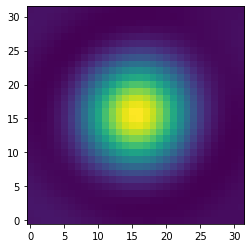

In [19]:
plt.imshow(psf_im,origin='lower')

In [20]:
def twoD_GaussianScaledAmp(data, xo, yo, sigma_x, sigma_y, amplitude, offset):
    (x,y)=data
    xo = float(xo)
    yo = float(yo)    
    g = offset + amplitude*np.exp( - (((x-xo)**2)/(2*sigma_x**2) + ((y-yo)**2)/(2*sigma_y**2)))
    return g.ravel()

def getFWHM_GaussianFitScaledAmp(img):

    x = np.linspace(0, img.shape[1], img.shape[1])
    y = np.linspace(0, img.shape[0], img.shape[0])
    x, y = np.meshgrid(x, y)
    #Parameters: xpos, ypos, sigmaX, sigmaY, amp, baseline
    initial_guess = (img.shape[1]/2,img.shape[0]/2,10,10,1,0)
    # subtract background and rescale image into [0,1], with floor clipping
    bg = np.percentile(img,5)
    img_scaled = np.clip((img - bg) / (img.max() - bg),0,1)
    popt, pcov = opt.curve_fit(twoD_GaussianScaledAmp, (x, y), 
                               img_scaled.ravel(), p0=initial_guess,
                               bounds = ((img.shape[1]*0.4, img.shape[0]*0.4, 1, 1, 0.5, -0.1),
                                     (img.shape[1]*0.6, img.shape[0]*0.6, img.shape[1]/2, img.shape[0]/2, 1.5, 0.5)))
    xcenter, ycenter, sigmaX, sigmaY, amp, offset = popt[0], popt[1], popt[2], popt[3], popt[4], popt[5]
    FWHM_x = np.abs(4*sigmaX*np.sqrt(-0.5*np.log(0.5)))
    FWHM_y = np.abs(4*sigmaY*np.sqrt(-0.5*np.log(0.5)))
    return (FWHM_x, FWHM_y)

#calling example: img is your image
(FWHM_x, FWHM_y) = getFWHM_GaussianFitScaledAmp(psf_im)
(FWHM_x, FWHM_y)

(12.228007710101181, 12.035690887141126)

# Perform Photmetry

In [ ]:
bkgrms = MADStdBackgroundRMS()
std = bkgrms(image[0:4000,0:4000])
fitter = LevMarLSQFitter()
photometry = DAOPhotPSFPhotometry(crit_separation = 2*int(FWHM_x), threshold= 10*std, fwhm= int(FWHM_x), 
                                  psf_model= final_psf, fitshape=3*int(FWHM_x), sharplo=0.2,
                                  sharphi=3, roundlo=-1, roundhi=1,
                                  fitter=fitter, aperture_radius = int(FWHM_x), niters=1)
result_tab = photometry(image=image[0:4000,0:4000])

In [9]:
zz=4000
norm = simple_norm(image, 'log', percent=99.99)
plt.figure(figsize=(10,10))
plt.xlim(0,zz)
plt.ylim(0,zz)
plt.imshow(image[0:zz,0:zz],norm=norm,origin='lower',cmap='Greys_r',vmin=0 ,vmax =1000)
plt.scatter(xg,yg,s=8,c='r')
plt.scatter(result_tab['x_fit'],result_tab['y_fit'],s=5,c='b')

12

# Analysis

In [ ]:
truth = gals['ind'].values[mask2]
fitting = []
fitmask = []
fail = truth


count=0
for i in np.arange(0,len(result_tab)):
    x = result_tab['x_fit'][i]
    y = result_tab['y_fit'][i]
    d = np.sqrt((xg-x)**2 + (yg-y)**2)
    if d.min()>10:
        count+=1
    else:
        fitting.extend(gals['mag'].values[mask2][np.where(d==d.min())])
        fitmask.extend(np.where(d==d.min()))
        
        
fail = np.delete(truth,fitmask) 

In [ ]:
ratio = np.histogram(np.unique(fitting),bins = np.arange(15.5,30.5,.5))[0]/np.histogram(gals['mag'].values[mask2],bins = np.arange(15.5,30.5,.5))[0]

In [ ]:
plt.scatter(np.arange(15.5,30,.5),rat)